In [3]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 0


In [4]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [ ]:
#Data Samples
#DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

#TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
#filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
#batch_size = 128
#train_set_size = int((5*10e5//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

In [7]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [8]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


In [109]:
particles_bg[:,:,2] = particles_bg[:,:,2]-0.5
particles_bg_valid[:,:,2] = particles_bg_valid[:,:,2]-0.5
particles_bg_test[:,:,2] = particles_bg_test[:,:,2]-0.5
particles_sig[:,:,2] = particles_sig[:,:,2]-0.5

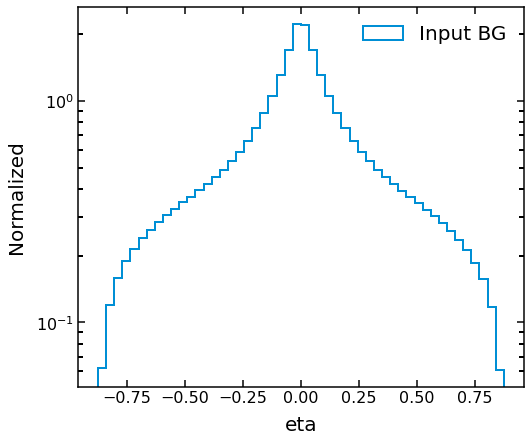

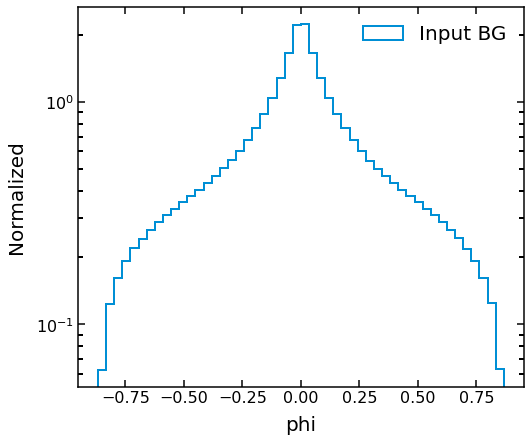

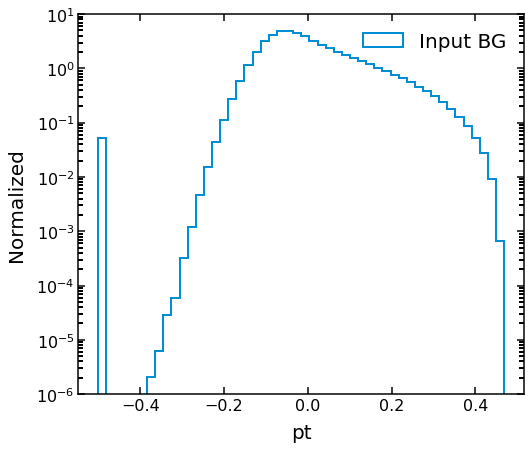

In [110]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [220]:
import tensorflow.keras.layers as klayers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

# Particle Net AE

In [235]:
class _DotDict:
    pass

setting = _DotDict()
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
        (20, (32, 32, 32)),
        (20, (64, 64, 64)),
#        (7, (64, 64, 64)),
#        (7, (32, 32, 32)),
#        (7, (64, 64, 64)),
        ]
setting.conv_params_decoder = [8,6] #[32,16,8, 5]
# conv_pooling: 'average' or 'max'
setting.conv_pooling = 'average'
setting.conv_linking = 'concat' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 30
setting.ae_type = 'vae'  #ae or vae 
setting.beta_kl = 10
setting.kl_warmup_time = 3
setting.activation = klayers.LeakyReLU(alpha=0.3)


In [236]:
model = pnae.PNVAE(setting=setting,name='PN_AE_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_122 (Tens [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_285 (Ten [(None, 50, 1, 3)]   0           features[0][0]                   
____________________________________________________________________________________

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128)]             0         
_________________________________________________________________
SamplingLayer (Functional)   [(None, 30), (None, 30),  7740      
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 30)]              0         
_________________________________________________________________
dense_38 (Dense)             (None, 400)               12400     
_________________________________________________________________
PN_AE__dense_0 (BatchNormali (None, 400)               1600      
________________________________________

In [242]:
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim)

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

kl_beta_callback = models.KLWarmupCallback()   


history = model.fit((particles_bg[:50000,:,0:2], particles_bg[:50000,:,:]) ,  particles_bg[:50000,:,:],
                    validation_data = ((particles_bg_valid[:50000,:,0:2], particles_bg_valid[:50000,:,:]) , particles_bg_valid[:50000,:,:]),
                    epochs=5, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls])  #,kl_beta_callback

Epoch 1/5
391/391 [==============================] - 21s 53ms/step - loss: 0.0356 - loss_reco: 0.0356 - loss_latent: 9.3272e-08 - val_loss: 0.0339 - val_loss_reco: 0.0339 - val_loss_latent: 5.9418e-08
Epoch 2/5
391/391 [==============================] - 20s 51ms/step - loss: 0.0348 - loss_reco: 0.0348 - loss_latent: 3.8737e-08 - val_loss: 0.0333 - val_loss_reco: 0.0333 - val_loss_latent: 3.6508e-08
Epoch 3/5
391/391 [==============================] - 20s 52ms/step - loss: 0.0345 - loss_reco: 0.0345 - loss_latent: 2.4098e-08 - val_loss: 0.0331 - val_loss_reco: 0.0331 - val_loss_latent: 2.6710e-08
Epoch 4/5
391/391 [==============================] - 20s 52ms/step - loss: 0.0343 - loss_reco: 0.0343 - loss_latent: 1.7601e-08 - val_loss: 0.0327 - val_loss_reco: 0.0327 - val_loss_latent: 2.0576e-08
Epoch 5/5
391/391 [==============================] - 20s 52ms/step - loss: 0.0341 - loss_reco: 0.0341 - loss_latent: 1.3987e-08 - val_loss: 0.0326 - val_loss_reco: 0.0326 - val_loss_latent: 1.1387

In [213]:
#models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
#model_path = models_dir + "output_model_saved_PN_AE_2021_07_30_T_09_26"
#loaded_model = tf.keras.models.load_model(
#    model_path,
#    custom_objects={"PN_AE": pn.get_particle_net_lite_ae, "threeD_loss":losses.threeD_loss}
#)

#weights_path = models_dir +'PN_AE_weights_2021_07_29_T_18_19.25-0.023.hdf5'
#loaded_model.load_weights(
#    weights_path, by_name=True, skip_mismatch=False)

In [243]:
#model = loaded_model

_,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
_,Y_sig_predict = model.predict([particles_sig[:,:,0:2],particles_sig])

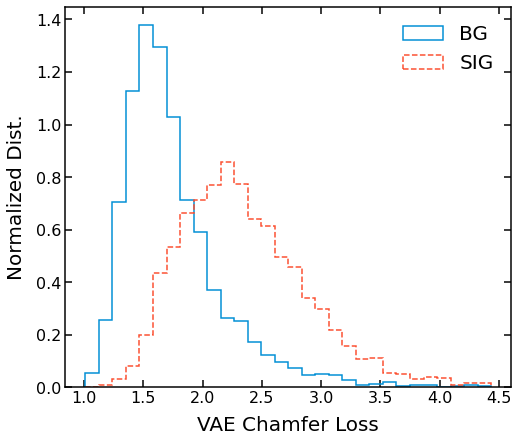

In [244]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)


plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_sig,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_vae.pdf'
plt.savefig(savename)
plt.show()

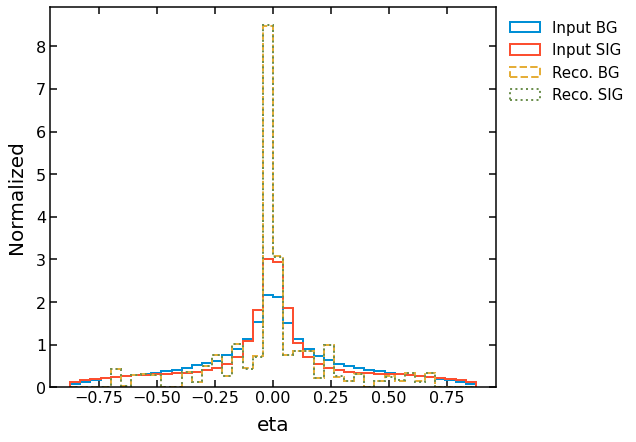

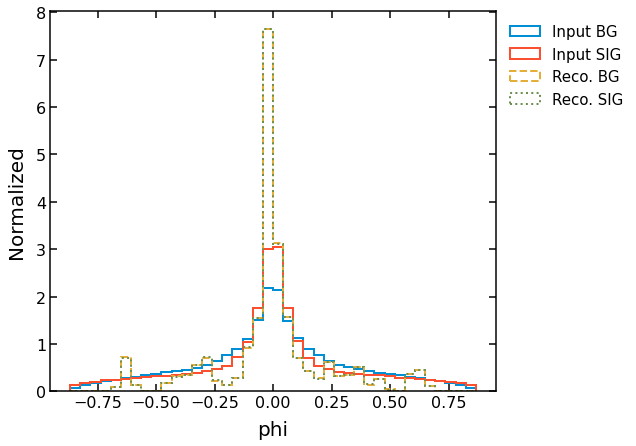

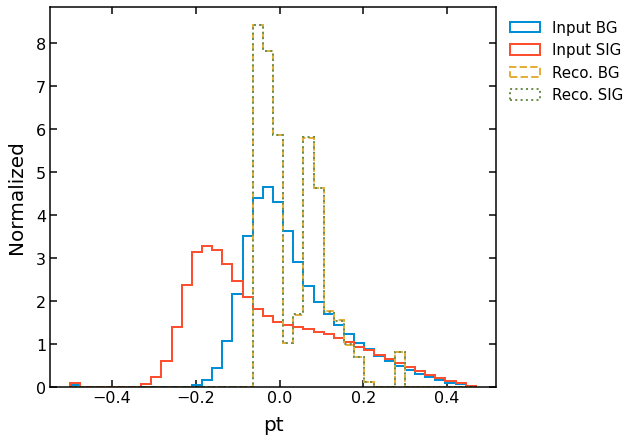

In [245]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    #plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_vae_{}.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


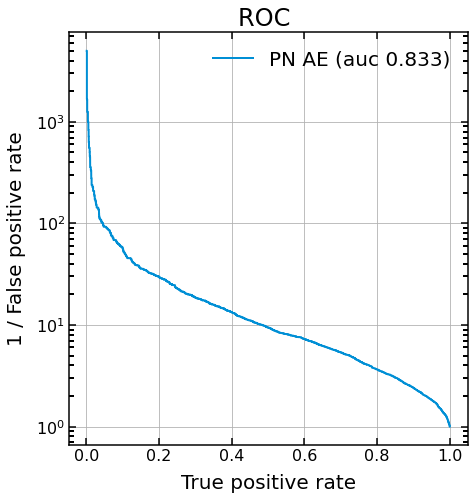

[0.8331962800000001]

In [246]:
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['PN AE'], title='ROC ',
            plot_name='ROC_pnae_test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [56]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))
